In [81]:
# Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qutip import *
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings('ignore')
from itertools import product

from scipy.optimize import minimize_scalar
from scipy.signal import argrelextrema

Let's remind ourselves of the Hamiltonian that we've been working with:

$$H =  A \sigma_z + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + \frac{\delta}{2}\left( a^{\dagger} + a \right)\sigma_x$$

The reason we chose A and $\delta$ is because of the path of discovery that we've taken to get here. From now on it will be convenient for us to re-write the Hamiltonian as:

$$H =  \frac{\Delta E}{2} \sigma_z + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)\sigma_x$$

where we recognise  $\Delta E$ as the difference in energy of our two state system which we will set as $\Delta E = 1$.


## Calculate energy eigenvalues for different couplings

In [420]:
delta_E = 1.0            # two level energy difference
N = 11                    # number of phonon quanta needed to exite the atom
omega = delta_E / N          # phonon energy
max_bosons =  100             # Max mode number to simulation
num_U = 100                  # number of different coupling strengths to try out (need 100 to reproduce SJByrnes Moiré pattern)
U_min = 0.01    # min atom phonon coupling
U_max = 0.2*delta_E     # maximum atom phonon coupling

In [421]:
a  = tensor(destroy(max_bosons+1), qeye(2))     # tensorised boson destruction operator
sx = tensor(qeye(max_bosons+1), sigmax())             # tensorised sigma_x operator
sz = tensor(qeye(max_bosons+1),sigmaz())              # tensorised sigma_z operator

two_state     =  delta_E/2*sz                          # two state system energy
bosons       =  omega*(a.dag()*a+0.5)          # bosons field energy
interaction   = (a.dag() + a) * sx     # interaction energy (needs to be multiplied by coupling constant)

number           = a.dag()*a  # phonon number operator
spin          = sz/2       # z component of spin

In [422]:
H = two_state + bosons + interaction

In [423]:
# f, ax = hinton(H)
# ax.tick_params(axis='x',labelrotation=90)
# ax.set_title("Matrix elements of H     (Fig 1)");

In [424]:
parity = "even"

In [425]:
#inspired by SJB code https://github.com/sbyrnes321/cf/blob/1a34a461c3b15e26cad3a15de3402142b07422d9/spinboson.py#L56
if parity != "all":
    S=1/2
    possible_ns = range(0, max_bosons+1)
    possible_ms = - (np.arange(2*S+1) - S)
    Smn_list = product([S], possible_ns, possible_ms)

    if parity == "even":
        mn_from_index = [(n,int(np.abs(m-0.5))) for (S,n,m) in Smn_list if (S+m+n) % 2 == 0]
    elif parity == "odd":
        mn_from_index = [(n,int(np.abs(m-0.5))) for (S,n,m) in Smn_list if (S+m+n) % 2 == 1]

    subset_idx = []
    for s in mn_from_index:
        subset_idx.append(state_number_index([max_bosons+1,2],s))
    
    # Labels for hinton plots in case we want to plot it later (use xlabels=ket_labels, ylabels = bra_labels)
    bra_labels = ["$\langle$"+str(n)+", "+str(m)+"|" for (n,m) in mn_from_index]
    ket_labels = ["|"+str(n)+", "+str(m)+"$\\rangle$" for (n,m) in mn_from_index]


In [426]:
    # http://qutip.org/docs/latest/apidoc/classes.html?highlight=extract_states#qutip.Qobj.extract_states
    two_state    = two_state.extract_states(subset_idx) 
    bosons      = bosons.extract_states(subset_idx) 
    interaction  = interaction.extract_states(subset_idx) 
    number          = (a.dag()*a).extract_states(subset_idx)
    spin         = spin.extract_states(subset_idx)

In [427]:
# H = two_state + bosons + interaction
# f, ax = hinton(H, xlabels=ket_labels, ylabels=bra_labels)
# ax.tick_params(axis='x',labelrotation=90)
# ax.set_title("Matrix elements of H     (Fig 1) EVEN");

In [428]:
d = {"coupling":np.linspace(U_min,U_max,num_U)}
for i in range((max_bosons+1)):
    d[f"level_{i}"] = np.zeros(num_U)
    
df = pd.DataFrame(data=d)


# We'll create some dataframes to store expectation values for: 
df_num = pd.DataFrame(data=d) # phonon number
df_sz = pd.DataFrame(data=d)  # z component of spin
df_int = pd.DataFrame(data=d) # interaction energy

In [429]:
for index, row in df.iterrows():
    # c.f. https://coldfusionblog.net/2017/07/09/numerical-spin-boson-model-part-1/
    H = two_state + bosons + row.coupling*interaction
    evals, ekets = H.eigenstates()
    df.iloc[index,1:] = np.real(evals/omega)
    
    # We'll also calculate some expectation values so we don't have to do it later
    df_num.iloc[index,1:] = expect(number,ekets)           # phonon number
    df_sz.iloc[index,1:] = expect(spin,ekets)           # z component of spin
    df_int.iloc[index,1:] = expect(row.coupling*interaction,ekets)   # interaction energy

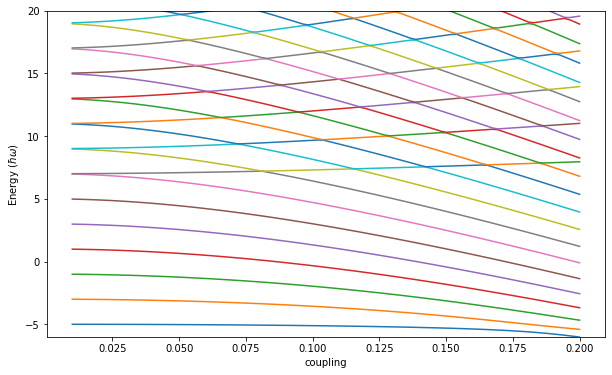

In [431]:
df.plot(x="coupling",ylim=[-6,20],figsize=(10,6),legend=False);
plt.ylabel("Energy ($\hbar\omega$)");

## More detail on energy levels 7 and 8

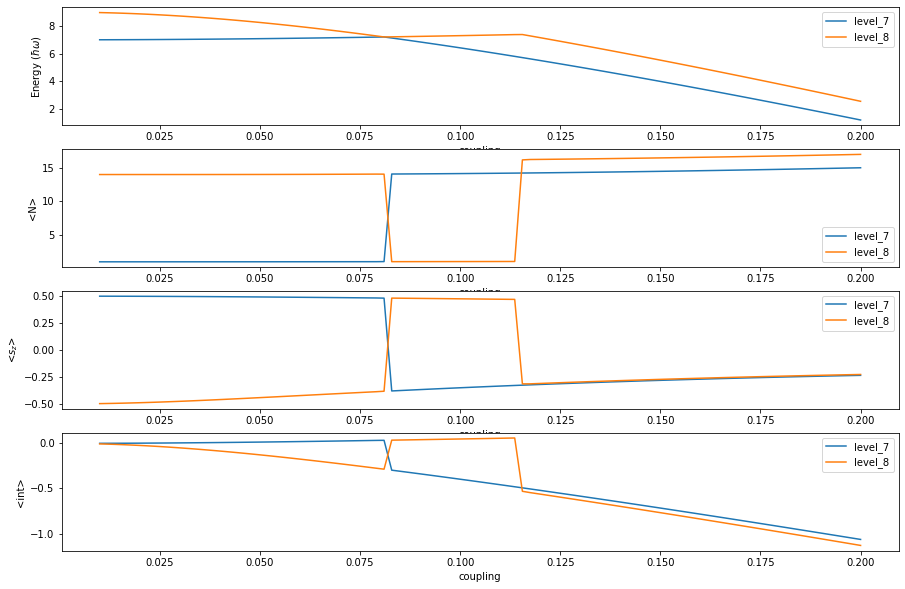

In [284]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,10))
df[["coupling","level_7","level_8"]].plot(x="coupling",ax=axes[0]);
df_num[["coupling","level_7","level_8"]].plot(x="coupling",ax=axes[1]);
df_sz[["coupling","level_7","level_8"]].plot(x="coupling",ax=axes[2]);
df_int[["coupling","level_7","level_8"]].plot(x="coupling",ax=axes[3]);
axes[0].set_ylabel("Energy ($\hbar\omega$)")
axes[1].set_ylabel("<N>")
axes[2].set_ylabel("<$s_z$>");
axes[3].set_ylabel("<int>");

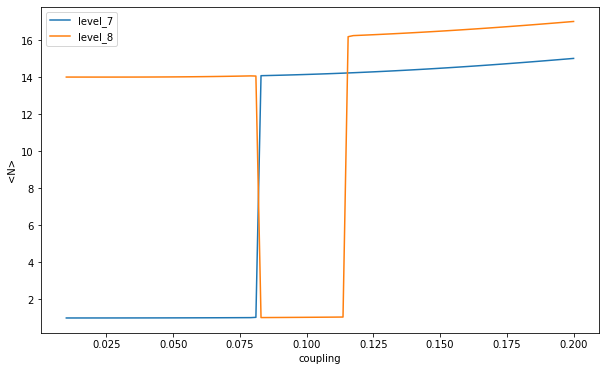

In [451]:
df_num[["coupling","level_7","level_8"]].plot(x="coupling",figsize=(10,6));
plt.ylabel("<N>");

## Find the anti-crossing point between levels 7 and 8

### Start with rough calculation of the anti-crossing coupling

In [444]:
df_diff = df.drop('coupling', axis=1).diff(axis=1).dropna(axis=1)
df_diff["coupling"] = df["coupling"]

In [445]:
df_diff_subset = df_diff[["coupling","level_8"]]
df_diff_subset["min"] =  df_diff_subset[["level_8"]].min(axis=1)
df_diff_subset["level_min"] = df_diff_subset[["level_8"]].idxmin(axis=1).str.split("_",expand = True)[1]

argmin = argrelextrema(df_diff_subset["min"].values, np.less)[0]
anti_crossing = df_diff_subset.iloc[argmin][["coupling","min","level_min"]]
anti_crossing.reset_index(inplace=True,drop=True)

In [446]:
anti_crossing

,coupling,min,level_min
0,0.08101,0.000938,8


### Now more precise calculation of anti-crossing coupling

In [447]:
# Define a function which returns the energy difference between two levels for a given coupling
def ev(U,i):
    H = two_state + bosons + U*interaction
    evals, ekets = H.eigenstates()
    return evals[i] - evals[i-1] 

In [448]:
dU = (U_max - U_min)/num_U

In [449]:
for index, row in anti_crossing.iterrows():
    res = minimize_scalar(ev,args=int(row["level_min"]),bracket=[row["coupling"]-dU, row["coupling"]+dU])
    anti_crossing.loc[index, "coupling"] = res.x
    anti_crossing.loc[index, "min"] = res.fun

In [450]:
anti_crossing

,coupling,min,level_min
0,0.081032,0.000006,8


## Simulation of the anti-crossing

### First let's look at some expectation values at the anti-crossing

In [460]:
# H = two_state + bosons + 0.01*interaction
# H = two_state + bosons + 0.531938*interaction # for N=1
# H = two_state + bosons + 0.08103160077219432*interaction # for N=11

H = two_state + bosons + anti_crossing.loc[0]["coupling"]*interaction
evals, ekets = H.eigenstates()

In [461]:
print("state", "energy", "number", "spin")
for i in range(0,10):
    print(i, evals[i]/omega, expect(number,ekets[i]), expect(spin,ekets[i]))

state energy number spin
0 -5.070746117470025 0.011939392534916488 -0.49371963416173986
1 -3.366544300732524 2.029024973288762 -0.467563108759075
2 -1.639524372889915 4.040808370651836 -0.44705781969562103
3 0.10512868232207373 6.049419433676879 -0.43020747999475756
4 1.8640387948480182 8.05595459255526 -0.41592745418562965
5 3.6348361327982843 10.06104671230085 -0.40355659770441704
6 5.415770326158273 12.065090487350574 -0.3926604011973573
7 7.205468801196486 7.544796808100654 0.04974662100209995
8 7.205530082600148 7.543955424634653 0.04975403063153744
9 9.002964722810209 16.070993041391787 -0.3741696612396334


We see above that levels 7 and 8 are almost identical which confirms what we see in the figures above

### What are the eigenstates for 7 and 8 made of?

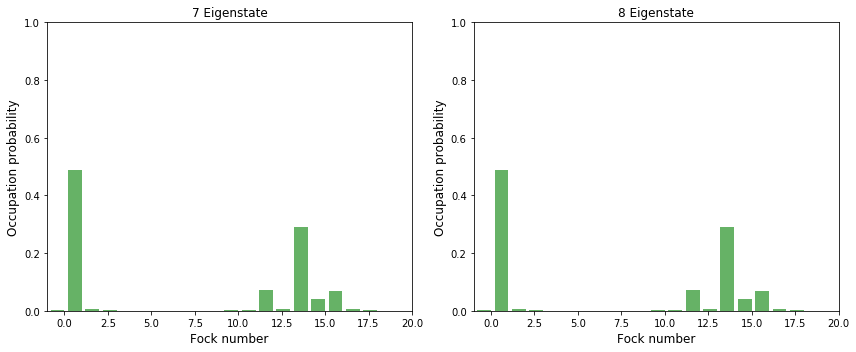

In [462]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
plot_fock_distribution(ekets[7], title="7 Eigenstate", ax=axes[0])
plot_fock_distribution(ekets[8],title="8 Eigenstate", ax=axes[1])
axes[0].set_xlim(-1,20)
axes[1].set_xlim(-1,20)
fig.tight_layout()

Energy eigenstates 7 and 8 are mostly made up of states numbered 1 and 14. But what do these correspond to. We can use our ket_labels for this:

In [463]:
print ( ket_labels[1], ket_labels[14])

|1, 0$\rangle$ |14, 1$\rangle$


### What does |1,0> look like in the basis of the eigenstates?

In [464]:
psi0 = tensor(basis(max_bosons+1, 1), basis(2, 0))
psi0 = psi0.extract_states(subset_idx) 

In [465]:
psi0_in_H_basis = psi0.transform(ekets)

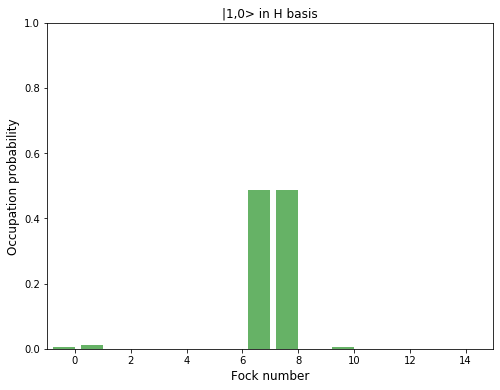

In [466]:
plot_fock_distribution(psi0_in_H_basis, title="|1,0> in H basis")
plt.xlim(-1,15);

so |1,0> (ie 1 bosons and lower state for two state system) is mixture of eigenstates 7 and 8.

Therefore if we start the system off in |1,0> we can expect it to rabi oscillate between 7 and 8 which should give us some oscilation between |1,0> and |14,1>. 

Let's see

In [469]:
P = []

for i in range(0,max_bosons):
    psi = basis(max_bosons,i)
    P.append(psi*psi.dag())

In [470]:
times = np.linspace(0.0, 100.0, 1000)      # simulation time

result = sesolve(H, psi0, times,P)

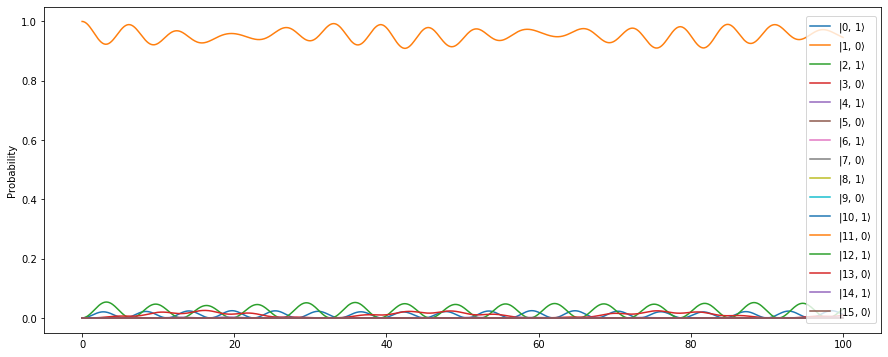

In [472]:
plt.figure(figsize=(15,6))

for i in range(0,16):
    plt.plot(times, result.expect[i], label=f"{ket_labels[i]}")
    
plt.ylabel("Probability")
plt.legend(loc="right")
plt.show();

Not much osccilation at all!

Maybe we need to wait longer. Let's manually do a time varying state

In [473]:
times = np.linspace(0.0, 1000000.0, 10000000)

In [474]:
PP = 0.7*np.exp(-1j*evals[7]*times) +  0.7*np.exp(-1j*evals[8]*times)

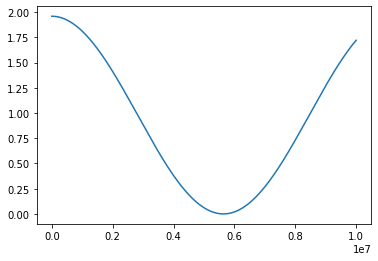

In [366]:
plt.plot(PP*np.conj(PP))

Seems like we'd have to wait a really long time to see the Rabi oscillation.